In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

DIR_INPUT = ''
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
DIR_WEIGHTS = ''

WEIGHTS_FILE = f'{DIR_WEIGHTS}model_state_epoch_7.pth'

In [2]:
class VinBigTestDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)

        dicom = pydicom.dcmread(os.path.join("train",f"{image_id}.dicom"))
        
        image = dicom.pixel_array
        
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        image = image.transpose(1,2,0)
       
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [3]:
# Albumentations
def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [4]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=False,
    pretrained_backbone=False,
    min_size=512,
    max_size=853
)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 15

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
model.eval()

x = model.to(device)

In [6]:
test_df = pd.read_csv(f'{DIR_INPUT}sample_submission.csv')
test_df.shape

(3000, 2)

In [8]:
print(test_df)

                              image_id PredictionString
0     002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1     004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2     008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1
3     009bc039326338823ca3aa84381f17f1     14 1 0 0 1 1
4     00a2145de1886cb9eb88869c85d74080     14 1 0 0 1 1
...                                ...              ...
2995  ff91fb82429a27521bbec8569b041f02     14 1 0 0 1 1
2996  ff9fcc4087ed5e941209aa3fa948e364     14 1 0 0 1 1
2997  ffaa288c8abca300974f043b57d81521     14 1 0 0 1 1
2998  ffc441e0c8b7153844047483a577e7c3     14 1 0 0 1 1
2999  ffccf1709d0081d122a1d1f9edbefdf1     14 1 0 0 1 1

[3000 rows x 2 columns]


In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [10]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [16]:
detection_threshold = 0.5
results = []

with torch.no_grad():

    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)
        

In [17]:
results[0:2]

[{'image_id': '002a34c58c5b758217ed1f584ccbcfe9',
  'PredictionString': '14 1.0 0 0 1 1'},
 {'image_id': '004f33259ee4aef671c2b95d54e4be68',
  'PredictionString': '0 0.7221 1249 585 1533 902'}]

In [18]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1.0 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,0 0.7221 1249 585 1533 902
2,008bdde2af2462e86fd373a445d0f4cd,14 1.0 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,3 0.7617 675 1081 1581 1354
4,00a2145de1886cb9eb88869c85d74080,14 1.0 0 0 1 1


In [19]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

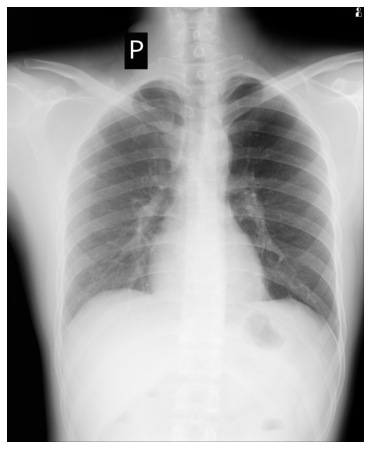

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [21]:
test_df.to_csv('submission.csv', index=False)

In [26]:
result_csv = pd.read_csv('submission.csv')
result_csv.shape

(3000, 2)

In [31]:
print(result_csv["PredictionString"][0])

14 1.0 0 0 1 1


In [41]:
count={}
for i in range(3000):
    #print(result_csv["PredictionString"][i].split(" "))
    #print("newline")
    temp=result_csv["PredictionString"][i].split(" ")
    for j in range(0,len(temp),6):
        #print(temp[j])
        if temp[j] not in count.keys():
            count[temp[j]]=1;
        else:
            count[temp[j]]+=1;

print(count)

{'14': 2206, '0': 663, '3': 454, '8': 63, '5': 41, '10': 127, '11': 62, '7': 14, '13': 68, '6': 1}


In [43]:
namelist ={'0':"Aortic enlargement",'1':"Atelectasis",'2':"Calcification",'3':"Cardiomegaly",'4':"Consolidation",'5':"ILD",'6':"Infiltration",'7':"Lung Opacity",'8':"Nodule/Mass",'9':"Other lesion",'10':"Pleural effusion",'11':"Pleural thickening",'12':"Pneumothorax",'13':"Pulmonary fibrosis",'14':"No finding"}

In [46]:
finalcount={}
for i in namelist.keys():
    if (i in count.keys()):
        finalcount[namelist[i]]=count[i]
    else:
        finalcount[namelist[i]]=0
print(finalcount)

{'Aortic enlargement': 663, 'Atelectasis': 0, 'Calcification': 0, 'Cardiomegaly': 454, 'Consolidation': 0, 'ILD': 41, 'Infiltration': 1, 'Lung Opacity': 14, 'Nodule/Mass': 63, 'Other lesion': 0, 'Pleural effusion': 127, 'Pleural thickening': 62, 'Pneumothorax': 0, 'Pulmonary fibrosis': 68, 'No finding': 2206}


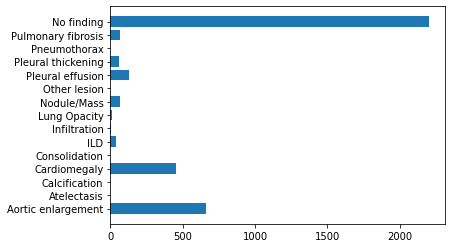

In [52]:
plt.barh(*zip(*finalcount.items()))
plt.show()

In [54]:
trainingdata = pd.read_csv('train.csv')
trainingdata.shape

(67914, 8)

In [59]:
traincount={}
for i in range(67914):
    #print(result_csv["PredictionString"][i].split(" "))
    #print("newline")
    temp=trainingdata["class_name"][i]
    #for j in range(0,len(temp),6):
        #print(temp[j])
    if temp not in traincount.keys():
        traincount[temp]=1;
    else:
        traincount[temp]+=1;

print(traincount)

{'No finding': 31818, 'Cardiomegaly': 5427, 'Aortic enlargement': 7162, 'Pleural thickening': 4842, 'ILD': 1000, 'Nodule/Mass': 2580, 'Pulmonary fibrosis': 4655, 'Lung Opacity': 2483, 'Atelectasis': 279, 'Other lesion': 2203, 'Infiltration': 1247, 'Pleural effusion': 2476, 'Calcification': 960, 'Consolidation': 556, 'Pneumothorax': 226}


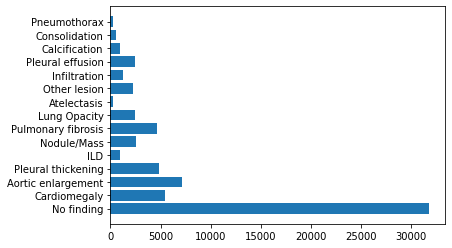

In [60]:
plt.barh(*zip(*traincount.items()))
plt.show()

In [21]:
train_df = pd.read_csv(f'{DIR_INPUT}train.csv')
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0

train_df.shape
train_df.sort_values(by='image_id').head(20)
image_ids = train_df['image_id'].unique()
print(image_ids.shape)
valid_ids = image_ids[-3000:]
train_ids = image_ids[:-3000]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
valid_df = valid_df.drop_duplicates(subset='image_id', keep="first")
valid_df.shape, train_df.shape

(15000,)


((3000, 8), (58324, 8))

In [22]:
valid_dataset = VinBigTestDataset(valid_df, DIR_TEST, get_test_transform())

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [23]:
detection_threshold = 0.5
results = []

with torch.no_grad():

    for images, image_ids in valid_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)
        

In [26]:
valid_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
valid_df.head()
valid_df.to_csv('validation.csv', index=False)

{'14': 2479, '0': 425, '8': 25, '3': 256, '13': 27, '11': 15, '5': 16, '10': 11, '7': 6}
{'Aortic enlargement': 425, 'Atelectasis': 0, 'Calcification': 0, 'Cardiomegaly': 256, 'Consolidation': 0, 'ILD': 16, 'Infiltration': 0, 'Lung Opacity': 6, 'Nodule/Mass': 25, 'Other lesion': 0, 'Pleural effusion': 11, 'Pleural thickening': 15, 'Pneumothorax': 0, 'Pulmonary fibrosis': 27, 'No finding': 2479}


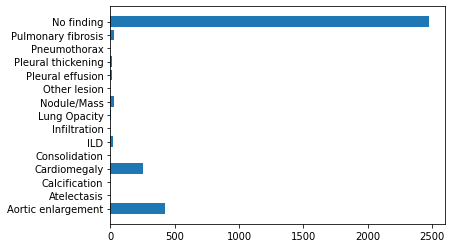

In [27]:
result_csv = pd.read_csv('validation.csv')
result_csv.shape
count={}
for i in range(3000):
    #print(result_csv["PredictionString"][i].split(" "))
    #print("newline")
    temp=result_csv["PredictionString"][i].split(" ")
    for j in range(0,len(temp),6):
        #print(temp[j])
        if temp[j] not in count.keys():
            count[temp[j]]=1;
        else:
            count[temp[j]]+=1;

print(count)
namelist ={'0':"Aortic enlargement",'1':"Atelectasis",'2':"Calcification",'3':"Cardiomegaly",'4':"Consolidation",'5':"ILD",'6':"Infiltration",'7':"Lung Opacity",'8':"Nodule/Mass",'9':"Other lesion",'10':"Pleural effusion",'11':"Pleural thickening",'12':"Pneumothorax",'13':"Pulmonary fibrosis",'14':"No finding"}
finalcount={}
for i in namelist.keys():
    if (i in count.keys()):
        finalcount[namelist[i]]=count[i]
    else:
        finalcount[namelist[i]]=0
print(finalcount)
plt.barh(*zip(*finalcount.items()))
plt.show()